In [1]:
import umap
import numpy as np
import numpy.linalg as la
import requests
import os
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import math
#Fashion mnist
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn import linear_model, ensemble, tree, neighbors, svm
from mnist.loader import MNIST
%notebook

UsageError: the following arguments are required: filename


In [2]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

Fetching Fashion-Mnist
Fashion-Mnist loaded


In [26]:
test_labels[1]

2

## Completion bar

In [3]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

## Rotation Algorithm

In [4]:
def rotate(theta,image):
    
    theta=math.radians(theta)                               #converting degrees to radians
    cosine=math.cos(theta)
    sine=math.sin(theta)
                                 
    
    # Compute augmented image dimensions
    new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
    new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

    #init temp matrix to be populated with individually rotated elements
    output=np.zeros((new_height,new_width))
    # Identify point of rotation in original image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
    original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image
    
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width 

            #Applying shear Transformation                     
            new_y,new_x=shear(theta,x,y)
            #Adjust coordinates to be relative to the new center after rotation
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            output[new_y,new_x]=image[i,j]                          #writing the pixels to the new destination in the output image
    """
    #trim output: 
    # iterate through matrix, if there exists an element less than tau round it down to 0
    tau=.1
    for j in range(output.shape[0]):
        for k in range(output.shape[0]):
            if output[j][k]<tau:
                output[j][k]=np.rint(output[j][k])
    # identify indices of zero rows and columns and delete them from the final matrix( could be done with less lines )
    idx = np.argwhere(np.all(output[..., :] == 0, axis=0))
    o2 = np.delete(output, idx, axis=0)
    idy = np.argwhere(np.all(output[..., :] == 0, axis=1))
    o3= np.delete(o2, idy, axis=1)
    return o3           
    """
    return output

In [5]:
# A shear is used here to avoid issues with anti aliasing, method described by 
#vhttps://www.ocf.berkeley.edu/~fricke/projects/israel/paeth/rotation_by_shearing.html
def shear(angle,x,y):
    '''
    |1  -tan(𝜃/2) |  |1        0|  |1  -tan(𝜃/2) | 
    |0      1     |  |sin(𝜃)   1|  |0      1     |
    '''
    
    tangent=math.tan(angle/2)
    new_x=round(x-y*tangent)
    new_y=y
    
    new_y=round(new_x*math.sin(angle)+new_y)      #since there is no change in new_x according to the shear matrix
    new_x=round(new_x-new_y*tangent)              #since there is no change in new_y according to the shear matrix
    
    return new_y,new_x

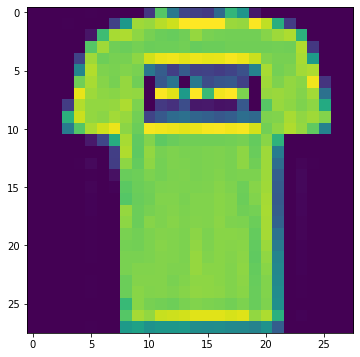

(41, 41)


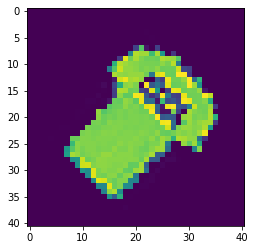

In [6]:
#testing rotations on sample image 


l=np.reshape(data[1],(28,28))
fig = plt.figure( figsize=(8, 6))
plt.imshow(l, cmap='viridis')
plt.show()

#fails for 5,6 degrees for some reason, debugging needed 
i=rotate(45,l)
print(i.shape)

plt.imshow(i, cmap='viridis')
plt.show()

## Experiment Design 

The following experiment is aimed at investigating different methodologies of correcting rotated images back to their canonical state. This investigation is being conducted in order to determine the worst case solution for improving umaps ability to handle rotational augmentations in the data. A high time complexity is expected most likely a quadratic addition as we will be preforming an additional evaluation for each step. Modifications will be done locally at first to test proficiency of the algorithm that scaled to a custom version of the umap embedding function where we can see how the sourrounding class structure handles modifications to the data. Today 9/20's develeopment process is cenetered around the goal of the local problem of identifying 1-3 different ways of correcting for rotational augmentations

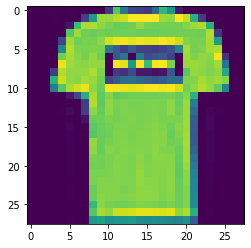

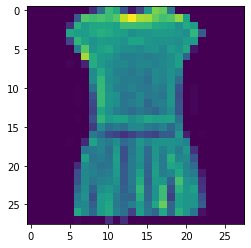

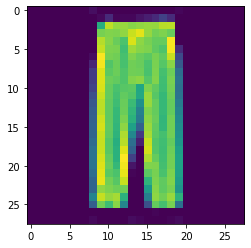

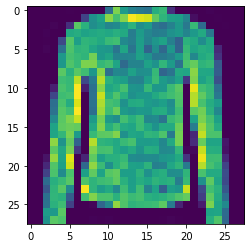

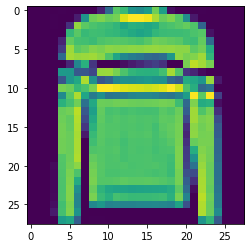

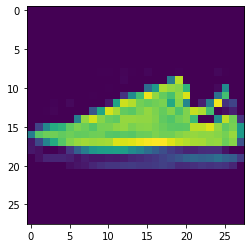

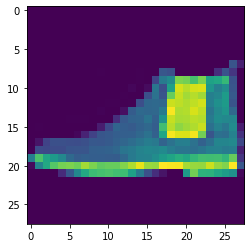

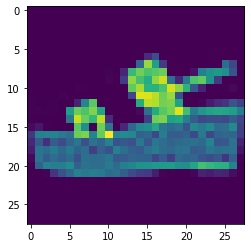

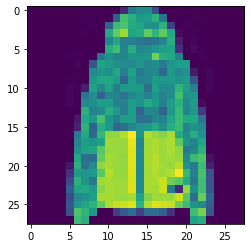

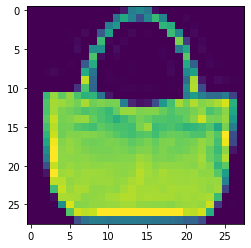

In [7]:
#define control samples for each clothing type 
tshirt_control=data[1]
plt.imshow(np.reshape(data[1],(28,28)), cmap='viridis')
plt.show()

dress_control=np.reshape(data[3],(28,28))
plt.imshow(dress_control, cmap='viridis')
plt.show()

trouser_control=np.reshape(data[21],(28,28))
plt.imshow(trouser_control, cmap='viridis')
plt.show()
#####
shirt_control=np.reshape(data[2222],(28,28))
plt.imshow(shirt_control, cmap='viridis')
plt.show()

pullover_control=np.reshape(data[5],(28,28))
plt.imshow(pullover_control, cmap='viridis')
plt.show()

sneaker_control=np.reshape(data[6],(28,28))
plt.imshow(sneaker_control, cmap='viridis')
plt.show()
####
ankle_control=np.reshape(data[111],(28,28))
plt.imshow(ankle_control, cmap='viridis')
plt.show()

sandal_control=np.reshape(data[12],(28,28))
plt.imshow(sandal_control, cmap='viridis')
plt.show()

coat_control=np.reshape(data[22],(28,28))
plt.imshow(coat_control, cmap='viridis')
plt.show()
####
bag_control=np.reshape(data[100],(28,28))
plt.imshow(bag_control, cmap='viridis')
plt.show()

In [8]:
control_samples=[
    tshirt_control,
    dress_control,
    trouser_control,
    shirt_control,
    pullover_control,
    sneaker_control,
    ankle_control,
    sandal_control,
    coat_control,
    bag_control
]
print(type(control_samples[1]))
print(np.shape(control_samples[1]))

<class 'numpy.ndarray'>
(28, 28)


test


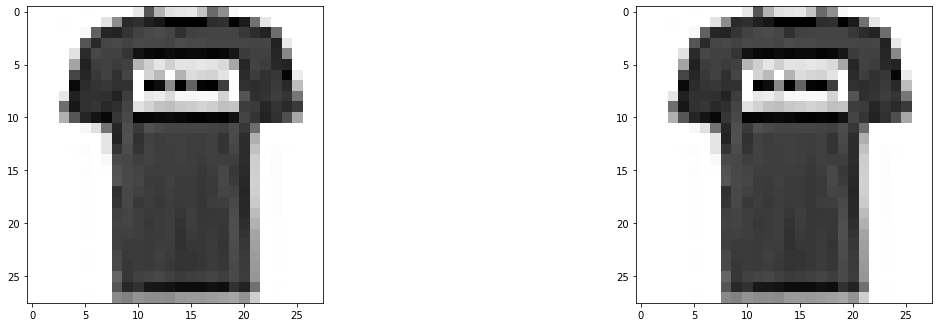

In [9]:
L_singular_vectors=[]
Sigma_matrices=[]
R_singular_vectors=[]
sample_digit=1
#Plot starting data for comparison to SVD reconstruction
fig = plt.figure(figsize=(20, 12))
fig.add_subplot(2, 2, 1)
plt.imshow(data[sample_digit].reshape(28,28), cmap='Greys', interpolation='nearest')

for i in range(10):
    #compute svd for the digit  i 
    u,s,v = la.svd(control_samples[i].reshape(28,28),full_matrices=False)
    L_singular_vectors.append(u.T)
    Sigma_matrices.append(s)# use np.diag(S) for nxn matrix of singular values 
    R_singular_vectors.append(v)
Us=np.array(L_singular_vectors).astype(float)
Ss=np.array(Sigma_matrices).astype(float)
Vs=np.array(R_singular_vectors).astype(float)
print("test")
fig.add_subplot(2, 2, 2)
plt.imshow(Us[sample_digit-1].T*Ss[sample_digit-1]@Vs[sample_digit-1], cmap='Greys', interpolation='nearest')

In [73]:
print(np.size(Us))
print(np.size(Ss))
print(np.size(Vs))

7840
280
7840


# Classifier function

In [10]:
# Classification function, returns the classification of a given sample based on the norm of the orthogonal complement
# this methodology allows us to quantify similarity by examining how far away each test sample is from the orthonormal basis 
# associated with each digit matrix picking the one with the smallest distance

def classify_y(Us, y, r):
    min_val = float('inf')
    classification = 0
    U_rs = [U[:r] for U in Us]
    for i,U_r in enumerate(U_rs):
        x_i = la.solve(U_r@U_r.T,U_r@y)
        diff = la.norm(y-U_r.T@x_i)
        if diff < min_val:
            min_val = diff
            if(i==0):
                classification=10
            else:
                classification = i
    return classification

In [11]:
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

In [12]:
# A small printing function used for printing clothes as human interpretable images
def print_item(y):
    fig = plt.figure(figsize=(20, 12))
    fig.add_subplot(2, 2, 1)
    plt.imshow(y.reshape(28,28), cmap=plt.get_cmap('viridis')) 
    plt.grid()
    plt.show()

In [71]:
#Classify the test digits using the SVD of the training digits for varying numbers of basis vectors. 
#store number of incorrect samples into a matrix to be plotted at a later date
incorrect_samples=0
basis_performance=[]
Basis_errors=[[],[],[],[],[],[],[]]

for j in range(0,7):
    print("testing ",4*j+4," basis vectors")
    incorrect_classification=[]
    Classifications=[]
    num_basis_vecs=4*j
    
    #classify test data
    for i in range(1000):
        Classifications.append(classify_y(Us,data[i].reshape(28,28),num_basis_vecs)) 
        
    #count failed classifications
    for i in range(1000):
        if Classifications[i]!=test_labels[i]:
            incorrect_classification.append(Classifications[i])
            incorrect_samples=incorrect_samples+1  
            
    for i in range(0,10):
      
        if i==0:
            error=countX(incorrect_classification,10)/incorrect_samples
            #print("Percentage of errors that are 0:",error)
        else:
            error=countX(incorrect_classification,i)/incorrect_samples
            #print("Percentage of errors that are",i,":",error)
        Basis_errors[j].append(error)   
    
   
    #cache performance for a set of basis vectors and reset for the next attempt        
    basis_performance.append(incorrect_samples)
    incorrect_samples=0
    print("===============")

testing  4  basis vectors
testing  8  basis vectors
testing  12  basis vectors
testing  16  basis vectors
testing  20  basis vectors
testing  24  basis vectors
testing  28  basis vectors


In [72]:
print(basis_performance)

[1000, 911, 902, 913, 928, 945, 938]


## Rotating 50%  by 200 degrees

In [32]:
#rotating 50% of the data by 150deg
theta=200
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r200_data=np.zeros((data.shape[0],sample_rotation_dim)) #casting all data to the size of rotation even for those not rotated to ensure homegenity in data

for i in range(np.shape(data)[0]):  
    if(i%2==0):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r200_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])

Progress: [####################] 99.5%


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
#for i in range(np.shape(data)[0]):     
  #  print(np.shape(r200_data[i]))
    # debug loop^ 

## Padding Singular vectors with zeros 

To reuse the same svd decompositions we will need to pad the singular vector matrices U and V t with zeros to ensure dimensionality agreement

(28, 28)


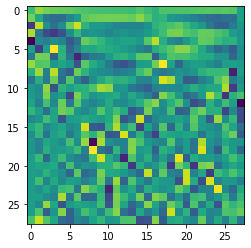

In [68]:
print(np.shape(Us[1]))
plt.imshow(Us[1], cmap='viridis')
plt.show()

In [49]:
print(np.shape(r200_data[1]))
n=np.shape(r200_data[1])[0]
n=math.sqrt(n)
m=n
Us_R=np.zeros((10,int(m),int(n)))
print(n,m)
print(np.shape(Us))

for i in range(np.shape(Us)[0]):
    #print(math.sqrt(r200_data[i].shape[0]))
    #temp=np.reshape(r200_data[i],(int(math.sqrt(r200_data[i].shape[0])),int(math.sqrt(r200_data[i].shape[0]))))
    #print(np.shape(temp))
    Us_R[i]= np.pad(Us[i], [(0, int(m)-np.shape(Us)[1]), (0, int(n)-np.shape(Us)[1])], mode='constant')
    
print(np.shape(Us_R))

(1369,)
37.0 37.0
(10, 28, 28)
(10, 37, 37)


In [115]:
#Classify the test digits using the SVD of the training digits for varying numbers of basis vectors. 
#store number of incorrect samples into a matrix to be plotted at a later date
incorrect_samples=0
basis_performance_rotations=[]
Basis_errors=[[],[],[],[],[],[],[]]

for j in range(0,7):
    print("testing ",4*j+4," basis vectors")
    incorrect_classification=[]
    Classifications=[]
    num_basis_vecs=4*j
    
    #classify test data
    for i in range(10000):
        Classifications.append(classify_y(Us_R,r200_data[i].reshape(37,37),num_basis_vecs)) 
        
    #count failed classifications
    for i in range(10000):
        if Classifications[i]!=test_labels[i]:
            incorrect_classification.append(Classifications[i])
            #if(i%42==0):
                #print_item(data[i])
                #print(Classifications[i],test_labels[i])
            incorrect_samples=incorrect_samples+1  
            
    for i in range(0,10):
      
        if i==0:
            error=countX(incorrect_classification,10)/incorrect_samples
            #print("Percentage of errors that are 0:",error)
        else:
            error=countX(incorrect_classification,i)/incorrect_samples
            #print("Percentage of errors that are",i,":",error)
        Basis_errors[j].append(error)   
    
   
    #cache performance for a set of basis vectors and reset for the next attempt        
    basis_performance_rotations.append(incorrect_samples)
    incorrect_samples=0
    print("===============")

testing  4  basis vectors
testing  8  basis vectors
testing  12  basis vectors
testing  16  basis vectors
testing  20  basis vectors
testing  24  basis vectors
testing  28  basis vectors


In [116]:
print(basis_performance)
print(basis_performance_rotations)

[1000, 911, 902, 913, 928, 945, 938]
[10000, 9493, 9488, 9524, 9520, 9631, 9651]


In [82]:

control_final_performance=(np.asarray(basis_performance)/np.shape(data)[0])*100
rotation_final_performance=(np.asarray(basis_performance_rotations)/np.shape(data)[0])*100
for i in range(np.shape(control_final_performance)[0]):
    control_final_performance[i]=100-control_final_performance[i]
    rotation_final_performance[i]=100-rotation_final_performance[i]
print(control_final_performance)
print(rotation_final_performance)

70000
[98.57142857 98.69857143 98.71142857 98.69571429 98.67428571 98.65
 98.66      ]
[98.57142857 98.63857143 98.64428571 98.63428571 98.63571429 98.62
 98.61714286]


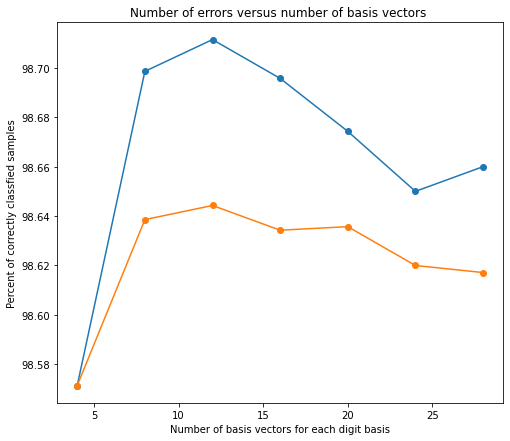

In [85]:
#Plot the results for different singular vector quantities
fig = plt.figure(figsize=(8, 7))
x=np.array(([4,8,12,16,20,24,28]))
plt.plot(x,control_final_performance,'o-')
plt.plot(x,rotation_final_performance,'o-')
plt.title("Number of errors versus number of basis vectors ")
plt.xlabel("Number of basis vectors for each digit basis")
plt.ylabel("Percent of correctly classfied samples")
plt.show()

So it can be seen that in general rotations worsen the quality of the classifier, although it is only by a small amount about .06% or less which is very negligble. 

In [95]:
def modified_classify( Us, y, r):
        y=np.reshape(y,(28,28))
        classifications = []
        U_rs = [U[:r] for U in Us]
        for i,U_r in enumerate(U_rs):
            x_i = la.solve(U_r@U_r.T,U_r@y)
            norm_z= la.norm(y-U_r.T@x_i)
            classifications.append(norm_z)
        return classifications

In [102]:
def calc_sig(significance, Us, y, r):
        #Classify with one basis vector
        classifications = modified_classify(Us, y, 1)
        
        # predicted number
        prediction = np.argmin(classifications)
        
        # value of diff
        prediction_val = classifications[prediction]
        classifications.pop(prediction)

        next_best = min(classifications)
        
        diff = next_best-prediction_val
        #If the difference is more than a tolerance level return the prediction otherwise
        #Use the old algorithm
        if diff > significance:
            return prediction if prediction !=0 else 10
        classifications = modified_classify(Us, y, r)
        prediction = np.argmin(classifications)

        return prediction if prediction !=0 else 10

In [114]:
print(np.shape(test_labels))
basis_performance2=[]
Basis_errors2=[[],[],[],[],[]]
for j in range(1,5):
    print("testing ",5*j," basis vectors")
    wrongly_classified = 0
    for i  in range(np.shape(data)[0]):
        
        if calc_sig(.6,Us, data[i], 5*j) != int(test_labels[i]): wrongly_classified+=1       
    basis_performance2.append(wrongly_classified)
    print(basis_performance2)
    
    for i in range(0,10):
        if i==0:
            error=countX(incorrect_classification,10)/wrongly_classified
        else:
            error=countX(incorrect_classification,i)/wrongly_classified
    Basis_errors2[j].append(error)      
    print("=======================")
    
print(basis_performance2)

(10000,)
testing  5  basis vectors


IndexError: array index out of range